**CONTEXT**

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

1-Personal Loan

2-EMI Free Loan

3-Personal Overdraft

4-Advance Salary Loan

This case study will focus on the underwriting process behind Personal Loan only

**PROBLEM STATEMENT:**

Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [23]:
loantap=pd.read_csv("/content/logistic_regression.csv")
loantap.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [24]:
loantap.shape

(66202, 27)

In [27]:
loantap.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [28]:
loantap.ndim

2

In [25]:
loantap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66202 entries, 0 to 66201
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             66202 non-null  float64
 1   term                  66202 non-null  object 
 2   int_rate              66202 non-null  float64
 3   installment           66202 non-null  float64
 4   grade                 66202 non-null  object 
 5   sub_grade             66202 non-null  object 
 6   emp_title             62409 non-null  object 
 7   emp_length            63156 non-null  object 
 8   home_ownership        66202 non-null  object 
 9   annual_inc            66202 non-null  float64
 10  verification_status   66202 non-null  object 
 11  issue_d               66202 non-null  object 
 12  loan_status           66202 non-null  object 
 13  purpose               66202 non-null  object 
 14  title                 65925 non-null  object 
 15  dti                

In [29]:
loantap.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,66202.000000,66202.000000,66202.000000,6.620200e+04,66202.000000,66202.000000,66202.000000,6.620200e+04,66152.000000,66201.000000,59932.000000,66126.000000
mean,14097.376212,13.649408,431.124613,7.425915e+04,17.327676,11.305671,0.179557,1.580884e+04,53.796393,25.443845,1.817226,0.122977
std,8363.302056,4.453394,250.660501,5.645242e+04,8.163720,5.114629,0.514185,1.995246e+04,24.401727,11.874131,2.153834,0.358023
min,500.000000,5.320000,16.310000,2.500000e+03,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.150000,4.500000e+04,11.280000,8.000000,0.000000,6.032000e+03,35.900000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.370000,6.392760e+04,16.840000,10.000000,0.000000,1.116000e+04,54.900000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,566.657500,9.000000e+04,22.920000,14.000000,0.000000,1.955300e+04,72.800000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,6.100000e+06,189.900000,57.000000,19.000000,1.190046e+06,150.700000,135.000000,34.000000,6.000000


In [40]:
loantap.describe(include='object')

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,earliest_cr_line,initial_list_status,application_type,address
count,66202,66202,66202,62409,63156,66202,66202,66202,66202,66202,65925,66202,66201,66201,66201
unique,2,7,35,37076,11,6,3,115,2,14,10418,611,2,3,66118
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,Oct-2001,f,INDIVIDUAL,USS Baker\r\nFPO AP 22690
freq,50398,19581,4535,734,21206,33165,23096,2488,53305,39114,25504,527,39766,66081,3


In [30]:
loantap.isnull().any()

loan_amnt               False
term                    False
int_rate                False
installment             False
grade                   False
sub_grade               False
emp_title                True
emp_length               True
home_ownership          False
annual_inc              False
verification_status     False
issue_d                 False
loan_status             False
purpose                 False
title                    True
dti                     False
earliest_cr_line        False
open_acc                False
pub_rec                 False
revol_bal               False
revol_util               True
total_acc                True
initial_list_status      True
application_type         True
mort_acc                 True
pub_rec_bankruptcies     True
address                  True
dtype: bool

In [31]:
loantap.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title               3793
emp_length              3046
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
title                    277
dti                        0
earliest_cr_line           0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  1
initial_list_status        1
application_type           1
mort_acc                6270
pub_rec_bankruptcies      76
address                    1
dtype: int64

In [32]:
loantap.isnull().sum().sum()

13516

<Axes: >

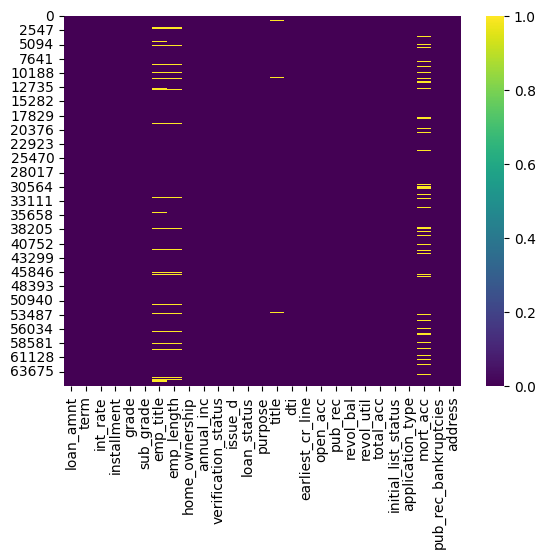

In [34]:
sns.heatmap(loantap.isnull(), cmap='viridis')

In [37]:
loantap.dtypes

loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
title                    object
dti                     float64
earliest_cr_line         object
open_acc                float64
pub_rec                 float64
revol_bal               float64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                float64
pub_rec_bankruptcies    float64
address                  object
dtype: object

In [39]:
loantap.duplicated().sum()

0

**UNIVARIATE ANALYSIS**

In [42]:
num_vars = loantap.select_dtypes('float64').columns.tolist()
num_vars

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

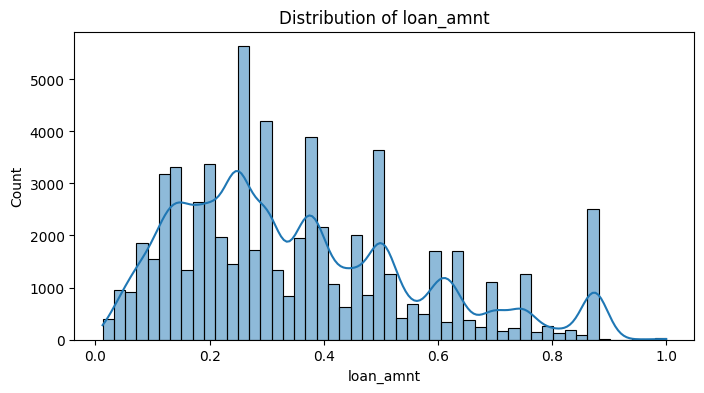

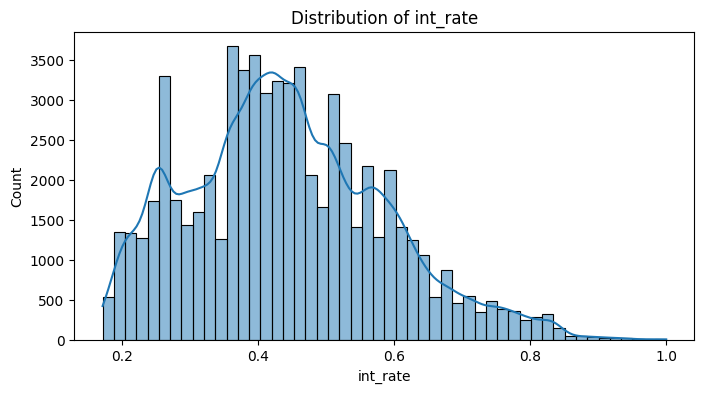

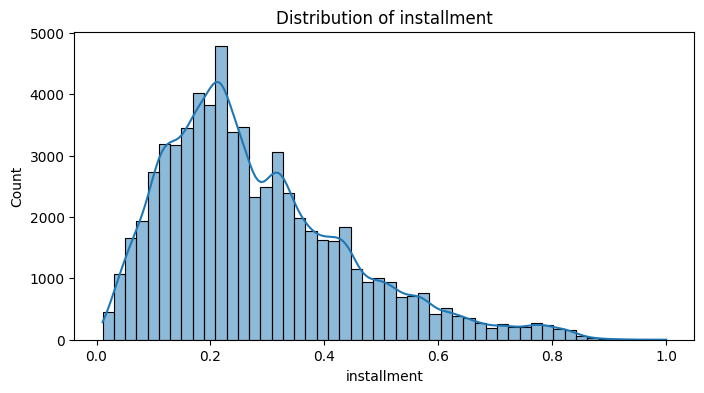

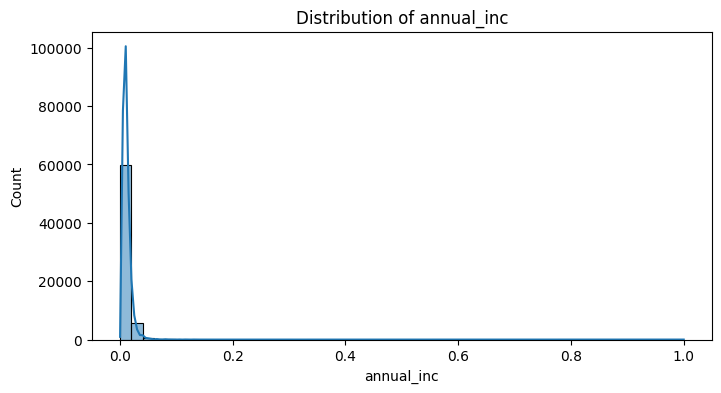

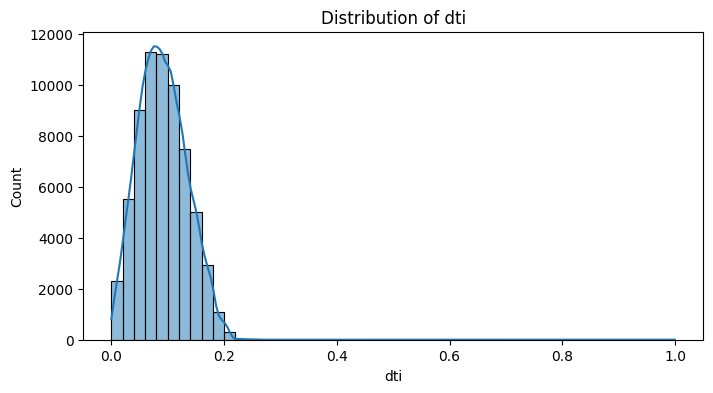

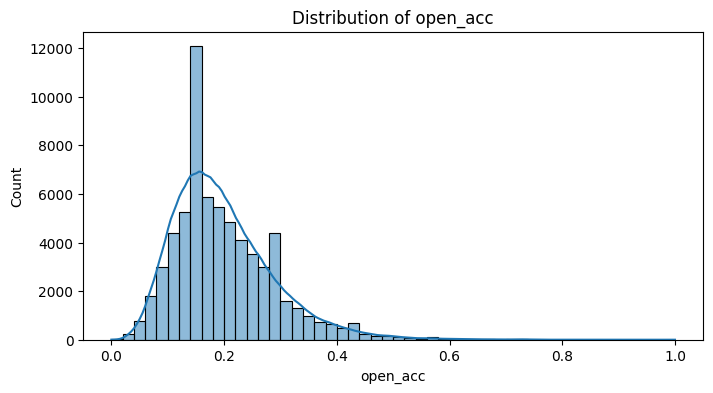

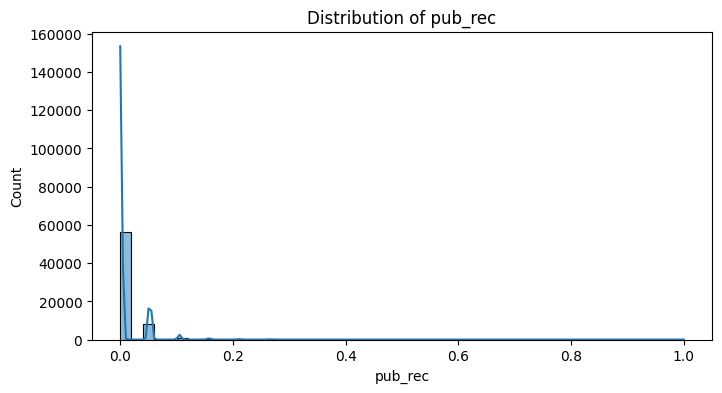

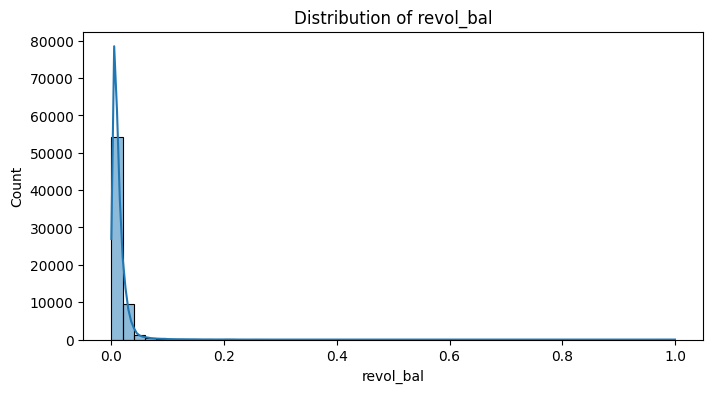

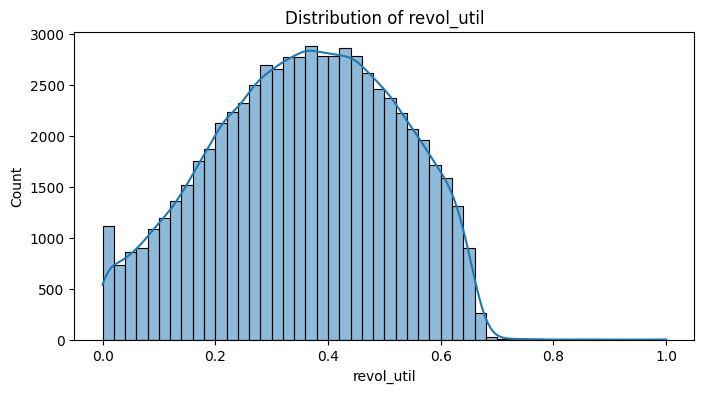

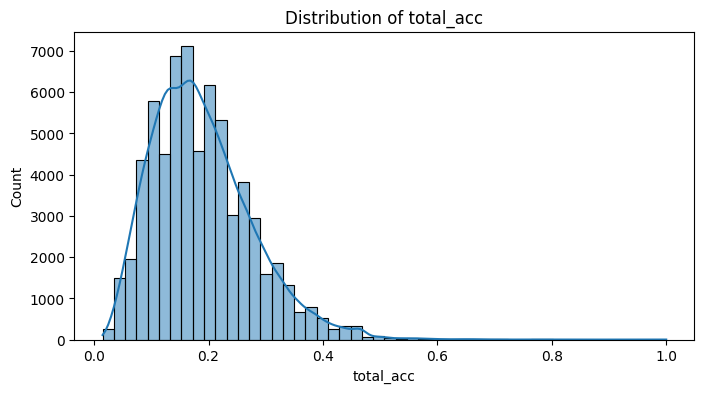

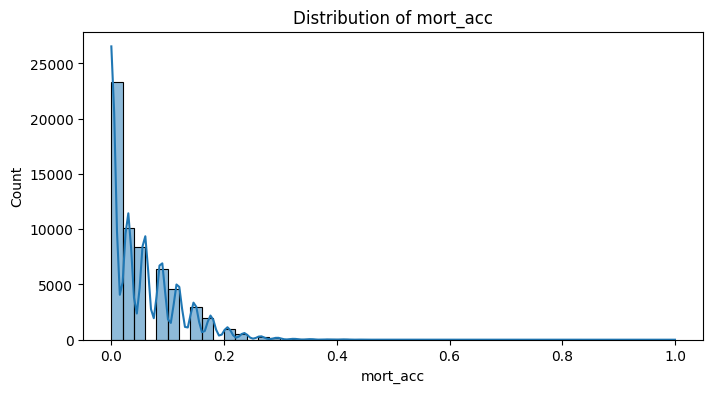

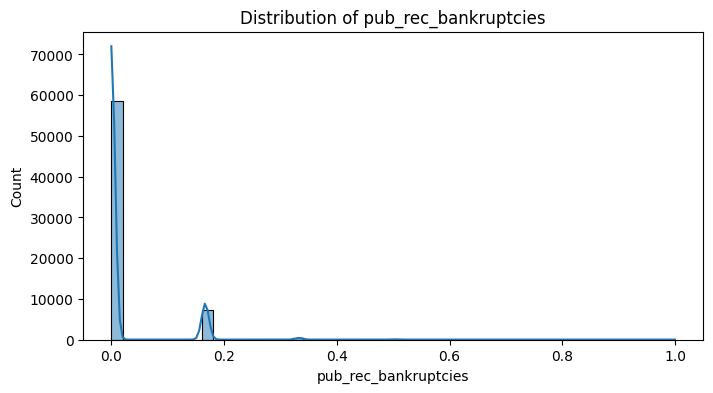

In [43]:
for i in num_vars:
    plt.figure(figsize=(8,4))
    plt.title("Distribution of {}".format(i))
    sns.histplot(loantap[i]/loantap[i].max(), kde=True, bins=50)
    plt.show()

*Most of the distribution is highly skewed which tells us that they
might contain outliers.

*Almost all the continuous features have outliers present in the dataset.

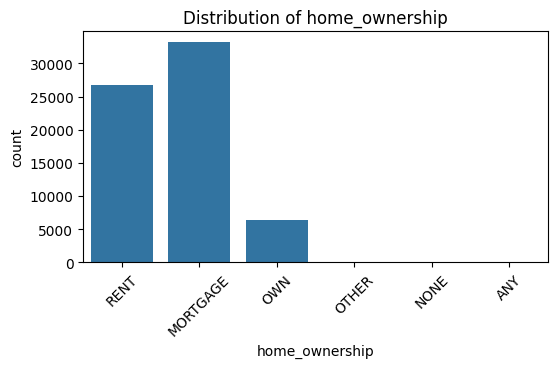

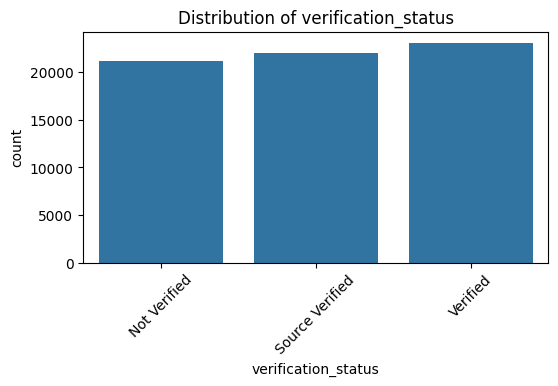

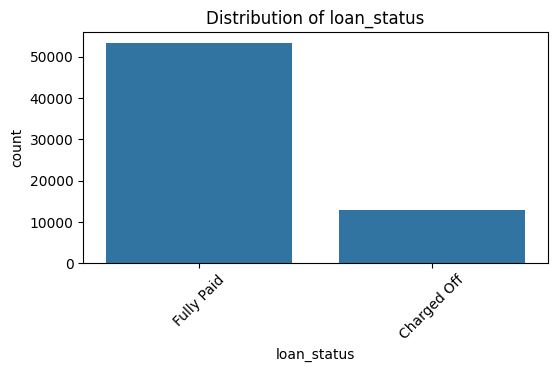

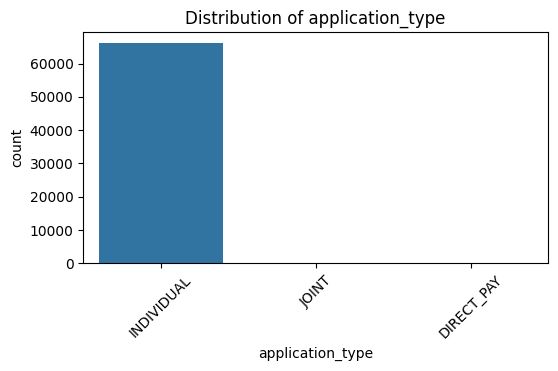

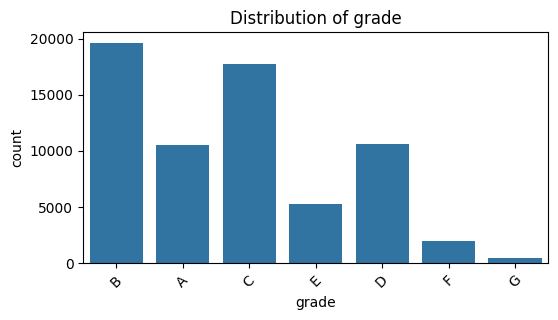

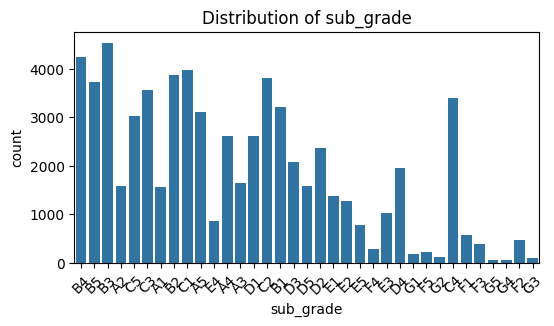

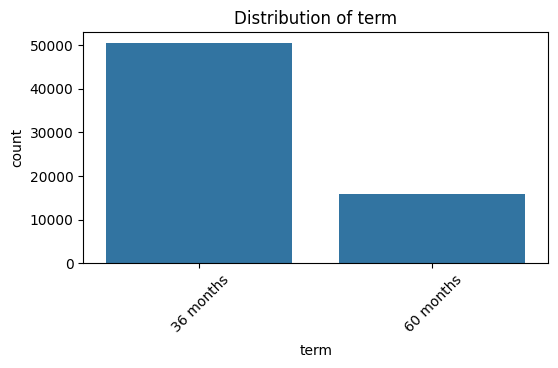

In [45]:
cat_vars = ['home_ownership', 'verification_status', 'loan_status', 'application_type', 'grade', 'sub_grade', 'term']
for i in cat_vars:
    plt.figure(figsize=(6,3))
    plt.title(f'Distribution of {i}')
    sns.countplot(data=loantap, x=i)
    plt.xticks(rotation = 45)
    plt.show()


*So from here we can infer that people with grade 'B' and subgrade 'B3' are more likely to fully pay the loan



* BIVARIATE ANALYSIS



<ipython-input-53-c3925a66c585>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
<ipython-input-53-c3925a66c585>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


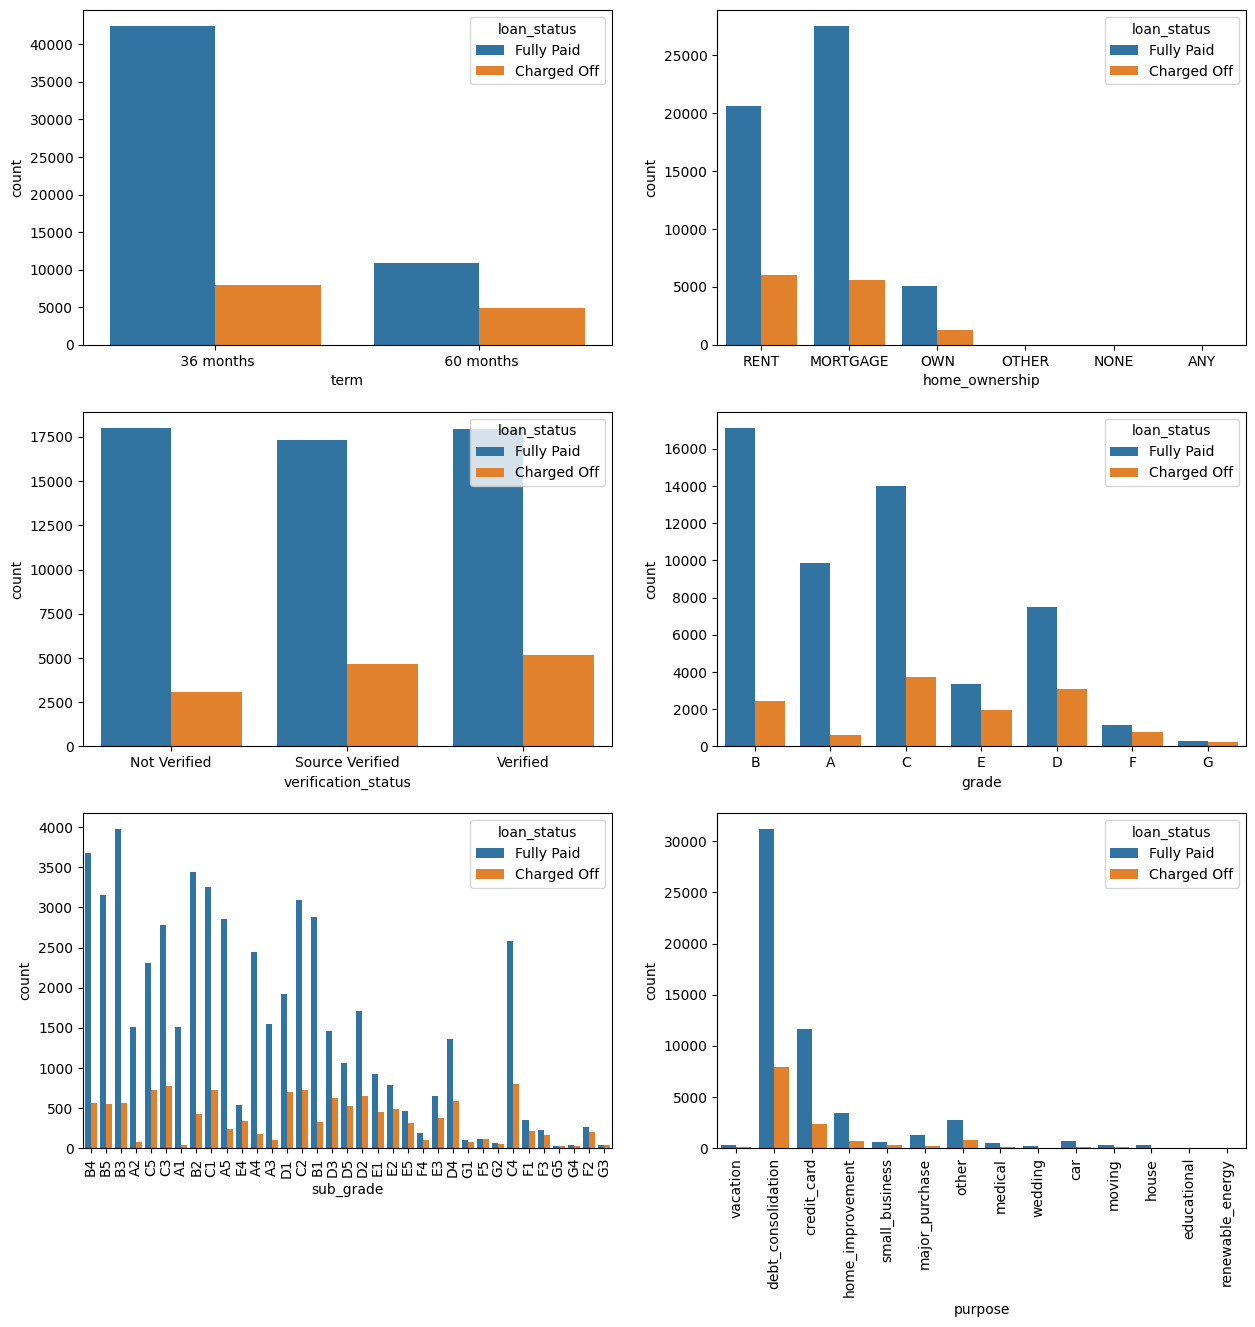

In [53]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
sns.countplot(x='term',data=loantap,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='home_ownership',data=loantap,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='verification_status',data=loantap,hue='loan_status')

plt.subplot(4, 2, 4)
sns.countplot(x='grade', data=loantap, hue='loan_status')

plt.subplot(4, 2, 5)
g = sns.countplot(x='sub_grade', data=loantap, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.subplot(4,2,6)
g=sns.countplot(x='purpose',data=loantap,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.show()



* Most of the people are taking loan for debt consolidations



<ipython-input-51-44761317f9b6>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(),rotation=90)


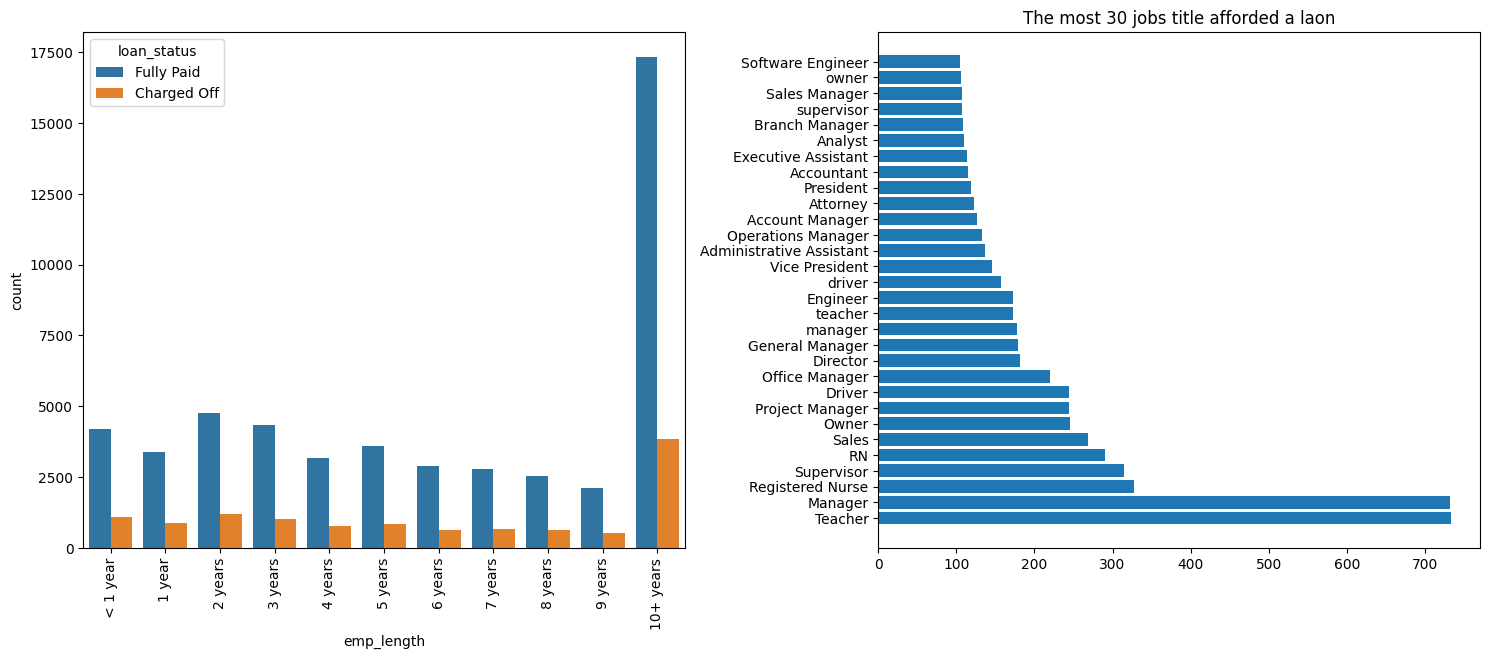

In [51]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g=sns.countplot(x='emp_length',data=loantap,hue='loan_status',order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(2,2,2)
plt.barh(loantap.emp_title.value_counts()[:30].index,loantap.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a laon")
plt.tight_layout()

plt.show()

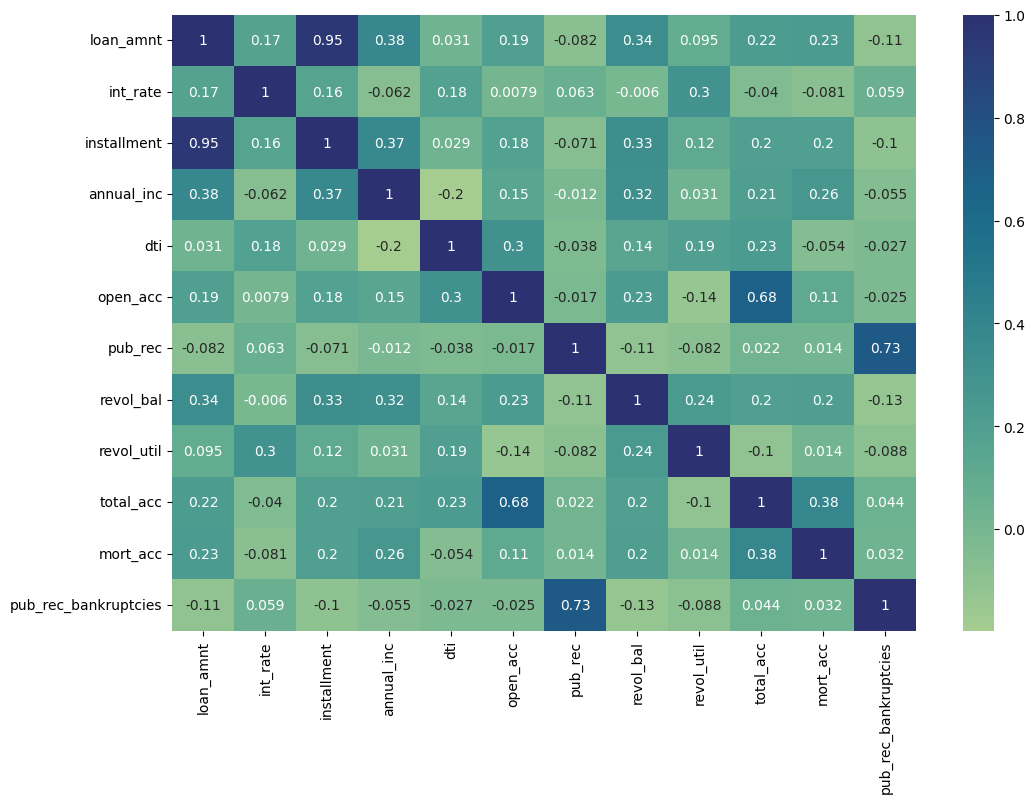

In [55]:
plt.figure(figsize=(12,8))
sns.heatmap(loantap.corr(numeric_only=True), cmap = 'crest', annot = True)

plt.show()

*We noticed almost perfect correlation between "loan_amnt" the "installment" feature so we can choose to drop either of these columns



FEATURE ENGINEERING



In [57]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number


def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number


In [58]:
loantap['pub_rec']=loantap.pub_rec.apply(pub_rec)
loantap['mort_acc']=loantap.mort_acc.apply(mort_acc)
loantap['pub_rec_bankruptcies']=loantap.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

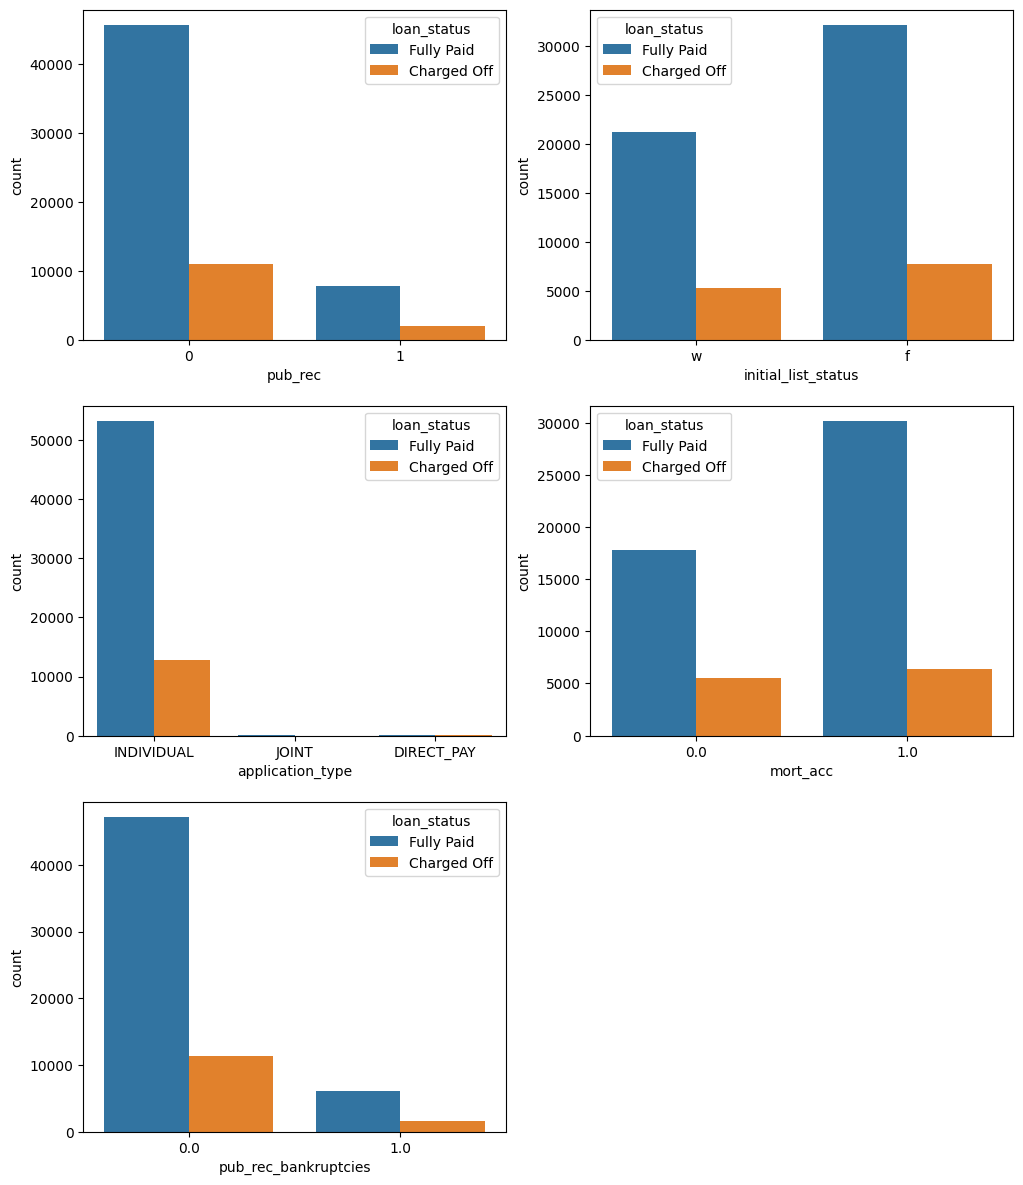

In [59]:
plt.figure(figsize=(12,30))

plt.subplot(6,2,1)
sns.countplot(x='pub_rec',data=loantap,hue='loan_status')

plt.subplot(6,2,2)
sns.countplot(x='initial_list_status',data=loantap,hue='loan_status')

plt.subplot(6,2,3)
sns.countplot(x='application_type',data=loantap,hue='loan_status')

plt.subplot(6,2,4)
sns.countplot(x='mort_acc',data=loantap,hue='loan_status')

plt.subplot(6,2,5)
sns.countplot(x='pub_rec_bankruptcies',data=loantap,hue='loan_status')

plt.show()

In [61]:
loantap.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title               3793
emp_length              3046
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
title                    277
dti                        0
earliest_cr_line           0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  1
initial_list_status        1
application_type           1
mort_acc                6270
pub_rec_bankruptcies      76
address                    1
dtype: int64

In [62]:
loantap.groupby(by='total_acc').mean()

<ipython-input-62-e64557836cad>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  loantap.groupby(by='total_acc').mean()


,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies
total_acc,,,,,,,,,,,
2.0,2793.750000,15.502500,94.485000,87000.000000,1.287500,1.250000,0.000000,2857.250000,57.425000,0.000000,0.000000
3.0,7386.885246,15.574262,239.848197,53163.390164,5.049508,2.655738,0.016393,3267.524590,43.105000,0.033333,0.000000
4.0,7832.908163,14.876173,261.742143,41109.000663,7.726939,3.255102,0.040816,4545.346939,55.269744,0.080292,0.030769
5.0,7989.386792,15.122013,262.660566,42909.555220,10.267170,3.871069,0.056604,5773.201258,58.158176,0.087137,0.044304
6.0,8551.629328,14.651914,277.386843,48177.703238,11.975540,4.543788,0.067210,6411.403259,57.881466,0.110831,0.040984
...,...,...,...,...,...,...,...,...,...,...,...
105.0,35000.000000,18.250000,1269.730000,130685.000000,26.310000,27.000000,0.000000,17406.000000,53.100000,1.000000,0.000000
106.0,12300.000000,21.990000,469.680000,42000.000000,15.060000,8.000000,0.000000,6630.000000,52.200000,0.000000,0.000000
108.0,13650.000000,25.090000,401.370000,45000.000000,27.150000,12.000000,0.000000,10838.000000,46.300000,0.000000,0.000000


In [66]:
import numpy as np

# Calculate mean of 'mort_acc' grouped by 'total_acc', handling NaN values
total_acc_avg = loantap.groupby(by='total_acc')['mort_acc'].mean().fillna(method='ffill').fillna(method='bfill')

# Define function to fill missing values in 'mort_acc'
def fill_mort_acc(total_acc, mort_acc):
    if pd.isna(mort_acc):
        return total_acc_avg.get(total_acc, np.nan)
    else:
        return mort_acc

# Apply the function to fill missing values in 'mort_acc' column
loantap['mort_acc'] = loantap.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)


In [67]:
loantap.isnull().sum()

loan_amnt                  0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title               3793
emp_length              3046
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
purpose                    0
title                    277
dti                        0
earliest_cr_line           0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                50
total_acc                  1
initial_list_status        1
application_type           1
mort_acc                   1
pub_rec_bankruptcies      76
address                    1
dtype: int64

In [68]:
#Dataset is very large so we can drop the rows with null values
# Dropping rows with null values
loantap.dropna(inplace=True)
# Remaining no. of rows
loantap.shape

(62026, 27)

In [69]:
loantap.isnull().sum().sum()

0

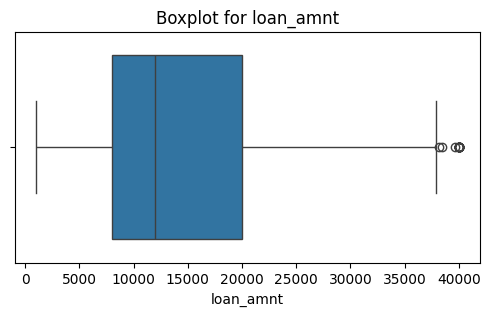

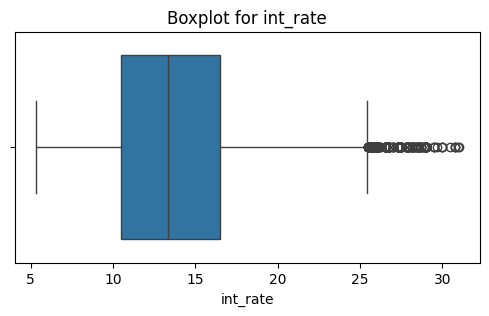

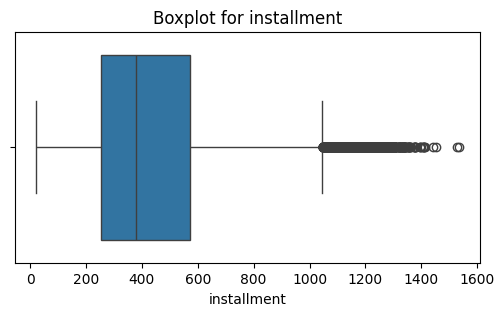

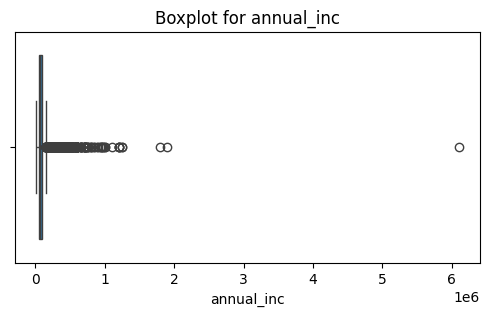

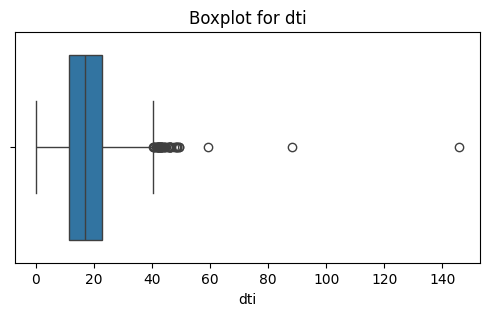

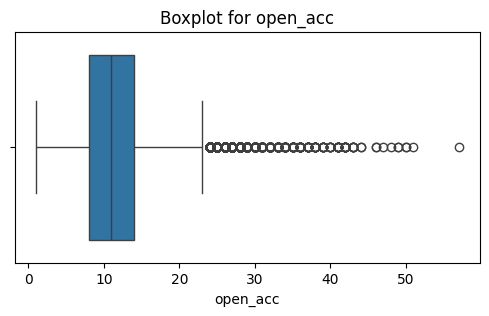

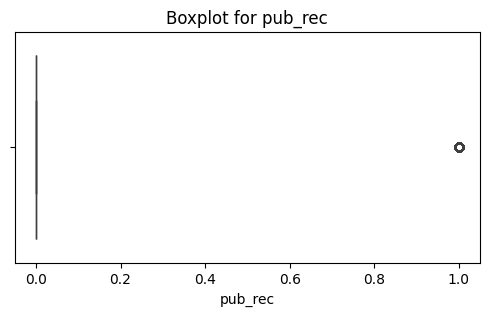

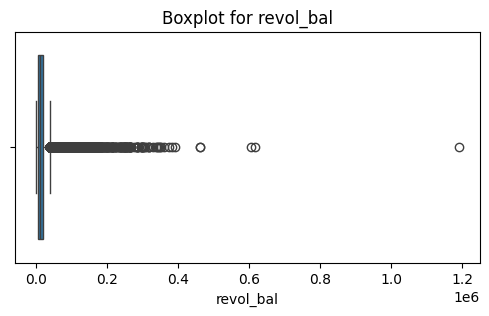

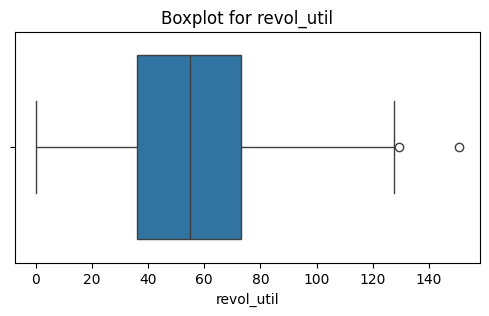

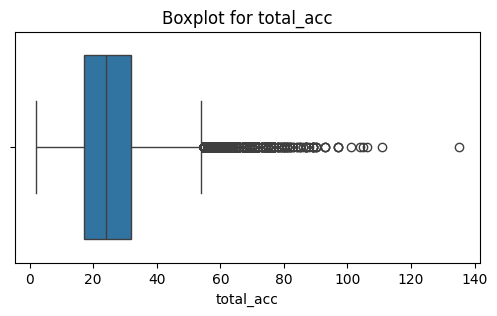

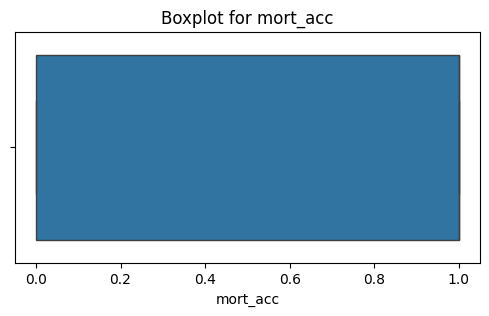

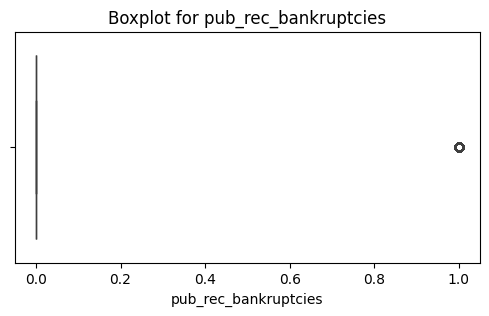

In [71]:
def box_plot(col):
    plt.figure(figsize=(6,3))
    sns.boxplot(x=loantap[col])
    plt.title('Boxplot for {}'.format(col))
    plt.show()

for col in num_vars:
    box_plot(col)

In [72]:
for col in num_vars:
    mean=loantap[col].mean()
    std=loantap[col].std()

    upper_limit=mean+3*std
    lower_limit=mean-3*std

    loantap=loantap[(loantap[col]<upper_limit) & (loantap[col]>lower_limit)]

loantap.shape

(58349, 27)

In [74]:
# Converting term values to numerical val
term_values={' 36 months': 36, ' 60 months':60}
loantap['term'] = loantap.term.map(term_values)

# Mapping the target variable
loantap['loan_status']=loantap.loan_status.map({'Fully Paid':0, 'Charged Off':1})

# Initial List Status
loantap['initial_list_status'].unique()
np.array(['w', 'f'], dtype=object)
list_status = {'w': 0, 'f': 1}
loantap['initial_list_status'] = loantap.initial_list_status.map(list_status)

# Let's fetch ZIP from address and then drop the remaining details -
loantap['zip_code'] = loantap.address.apply(lambda x: x[-5:])
loantap['zip_code'].value_counts(normalize=True)*100

70466    14.413272
22690    14.397847
30723    14.250458
48052    13.897410
29597    11.662582
05113    11.606026
00813    11.540900
93700     2.796963
11650     2.742121
86630     2.692420
Name: zip_code, dtype: float64

In [75]:
# Dropping some variables which we can let go for now
loantap.drop(columns=['issue_d', 'emp_title', 'title', 'sub_grade',
                   'address', 'earliest_cr_line', 'emp_length'],
                   axis=1, inplace=True)


ONE HOT ENCODING

In [76]:
dummies=['purpose', 'zip_code', 'grade', 'verification_status', 'application_type', 'home_ownership']
data=pd.get_dummies(loantap,columns=dummies,drop_first=True)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)


DATA PROCESSING FOR MODELLING

In [77]:
from sklearn.model_selection import train_test_split

X=data.drop('loan_status',axis=1)
y=data['loan_status']
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)
print(X_train.shape)
print(X_test.shape)

(40844, 51)
(17505, 51)


In [78]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


MODEL BUILDING

In [79]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [80]:
# X.columns.shape
# # logreg.coef_[0]
pd.Series((zip(X.columns, logreg.coef_[0])))

0                    (loan_amnt, -0.028345607650750927)
1                            (term, 0.5817636886646926)
2                       (int_rate, 0.35178878524076157)
3                      (installment, 0.653626210591888)
4                     (annual_inc, -0.9615607175903897)
5                             (dti, 1.0094585915267769)
6                       (open_acc, 0.42403993194095446)
7                         (pub_rec, 0.1072907620217704)
8                      (revol_bal, -0.4256858611979364)
9                     (revol_util, 0.32583385125971903)
10                     (total_acc, -0.4224313235434322)
11           (initial_list_status, 0.03185657794132519)
12                     (mort_acc, -0.08730817541771495)
13         (pub_rec_bankruptcies, -0.09946698035620323)
14          (purpose_credit_card, -0.02411939145575919)
15    (purpose_debt_consolidation, 0.014634601784871...
16            (purpose_educational, 0.7803446541547737)
17     (purpose_home_improvement, 0.034316202282

In [81]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.891


[[14087    66]
 [ 1842  1510]]


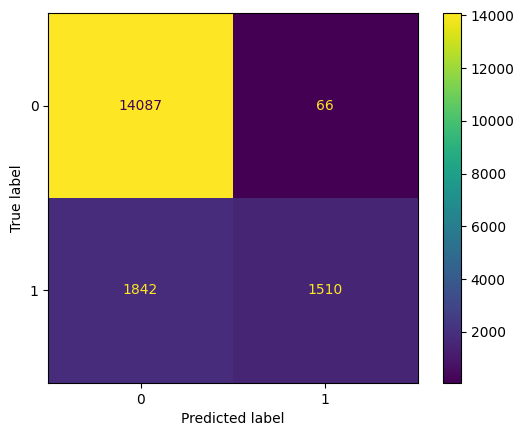

In [82]:
confusion_matrix=confusion_matrix(y_test,y_pred)
print(confusion_matrix)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=logreg.classes_).plot()

There is significant value for false negative and false positive. Which will hamper our prediction due to type-1 or type-2 err

In [83]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     14153
           1       0.96      0.45      0.61      3352

    accuracy                           0.89     17505
   macro avg       0.92      0.72      0.77     17505
weighted avg       0.90      0.89      0.87     17505



Precision score and recall score for full paid status is almost same indicates that model is doing decent job which correctly classified the both of the scenarios

Precision score for charged off status is more than recall score which is perfec

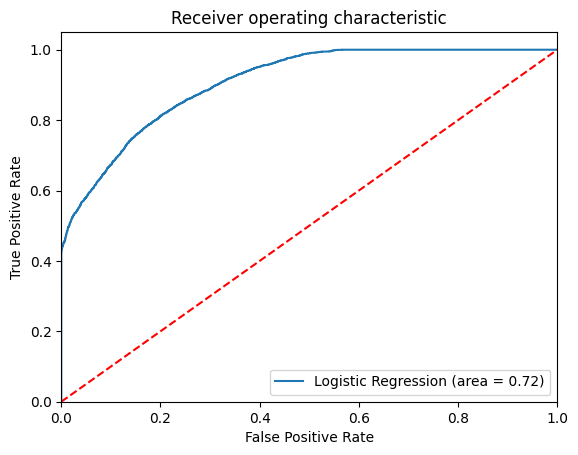

In [84]:
logit_roc_auc=roc_auc_score(y_test,logreg.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


ROC-AUC curve is grossing the area near about 0.73 which indicates that model is performing well.

There is still room for some model improvement
By collecting more data, using a more complex model, or tuning the hyperparameters, it is possible to improve the model's performance

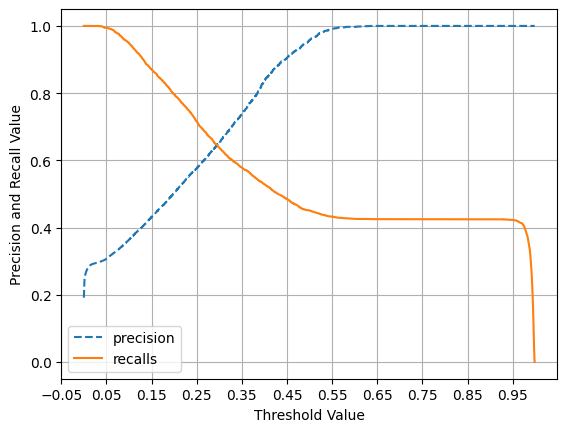

In [85]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')

    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,logreg.predict_proba(X_test)[:,1])

Precision score is highest at 0.55 threshold. High precision value indicates that model is positevly predicating the charged off loan status which helps business to take more stable decision.

Recall score is higher on smaller threshold but after 0.55 the recall value is constant. Model is correctly classifying the actual predicated values as instances.

**Assumption of Log. Reg. (Multicollinearity Check)**

In [86]:
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

calc_vif(X)[:5]


,Feature,VIF
44,application_type_INDIVIDUAL,4500.14
46,home_ownership_MORTGAGE,2310.45
50,home_ownership_RENT,1951.55
49,home_ownership_OWN,417.05
0,loan_amnt,236.05


In [87]:
X.drop(columns=['application_type_INDIVIDUAL'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
0,loan_amnt,236.03
3,installment,212.87
2,int_rate,129.65
1,term,124.45
45,home_ownership_MORTGAGE,102.39


In [88]:
X.drop(columns=['loan_amnt'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
1,int_rate,122.77
44,home_ownership_MORTGAGE,78.64
48,home_ownership_RENT,63.38
14,purpose_debt_consolidation,49.68
0,term,25.81


In [92]:
X.drop(columns=['home_ownership_MORTGAGE'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
13,purpose_debt_consolidation,22.59
0,term,22.02
4,open_acc,13.48
8,total_acc,12.60
7,revol_util,9.01


In [93]:
X.drop(columns=['purpose_debt_consolidation'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
0,term,18.10
4,open_acc,13.05
8,total_acc,12.60
7,revol_util,8.33
2,annual_inc,8.24


In [94]:
X.drop(columns=['term'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
3,open_acc,12.98
7,total_acc,12.53
6,revol_util,8.30
1,annual_inc,7.92
2,dti,7.56


In [95]:
X.drop(columns=['open_acc'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
6,total_acc,8.24
5,revol_util,7.99
1,annual_inc,7.82
2,dti,7.01
0,installment,6.65


**Validation using KFold**

In [97]:
X=scaler.fit_transform(X)

kfold=KFold(n_splits=5)
accuracy=np.mean(cross_val_score(logreg,X,y,cv=kfold,scoring='accuracy',n_jobs=-1))
print("Cross Validation accuracy : {:.3f}".format(accuracy))

Cross Validation accuracy : 0.891


Cross Validation accuracy and testing accuracy is almost same which infers model is performing the decent job.


**Oversampling using SMOTE**

In [98]:
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train.ravel())


In [99]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (66048, 51)
After OverSampling, the shape of train_y: (66048,) 

After OverSampling, counts of label '1': 33024
After OverSampling, counts of label '0': 33024


In [100]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)
predictions = lr1.predict(X_test)

# Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     14153
           1       0.49      0.81      0.61      3352

    accuracy                           0.80     17505
   macro avg       0.72      0.80      0.74     17505
weighted avg       0.86      0.80      0.82     17505



After making the dataset balanced, the precision and recall score are same as imbalanced dataset. But the accuracy dropped.

There is still room for improvement.

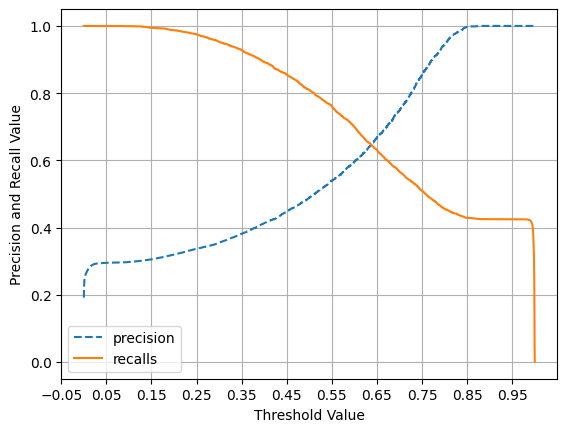

In [101]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr1.predict_proba(X_test)[:,1])


After balancing the dataset, there is significant change observed in the precion and recall score for both of the classes.

Precision score is .95 and .49 for full paid and charged off respectively.

**Questions**

Q-How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.


Answer - Since data is imbalances by making the data balance we can try to avoid false positives. For evaluation metrics, we should be focusing on the macro average f1-score because we don't want to make false positive prediction and at the same we want to detect the defualers.

Q-Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone

Answer - Below are the most features and their importance while making the prediction. So these variables can help the managers to identify which are customers who are more likely to pay the loan amount fully,

**INSIGHTS AND RECOMMENDATIONS**

1-80% of the customers have paid the loan fully.

2-20% of the customers are the defaulters.

3-The organization can the trained model to make prediction for whether a person will likely to pay the loan amount or he will be a defaulter.

4-Model achieves the 94% f1-score for the negative class (Fully Paid).

5-Model achieves the 62% f1-score for the positive class (Charged off).

6-Cross Validation accuracy and testing accuracy is almost same which infers model is performing the decent job. We can trust this model for unseen data

7-By collecting more data, using a more complex model, or tuning the hyperparameters, it is possible to improve the model's performance.

8-ROC AUC curve area of 0.73, the model is correctly classifying about 73% of the instances. This is a good performance, but there is still room for improvement.

9-The precision-recall curve allows us to see how the precision and recall trade-off as we vary the threshold. A higher threshold will result in higher precision, but lower recall, and vice versa. The ideal point on the curve is the one that best meets the needs of the specific application.

10-After balancing the dataset, there is significant change observed in the precion and recall score for both of the classes.

11-Accuracy of Logistic Regression Classifier on test set: 0.891 which is decent and not by chance.